# Analysis of results of running the OpenCL RAMP model with one-shot calibration of the model parameters

This notebook evaluates the performance of the OpenCL RAMP model ran with one-off calibration of the parameter values, in the RunModel_OneShotCalibration.py script. The current risk beta value which controls the general transmissability of the disease is set as a constant using the value determined in InitialModelCalibration.ipynb. 

It considers a scenario in which we are X days into a pandemic, and have X days worth of observed cases. We also have a model which describes the spread of the disease through the population, and an estimate (based on past knowledge of similar epidemics) of the prior distributions for the parameters driving the model. We can run this model for X days and calibrate the optimal posterior model parameters using ABC and the observations data over the full X days. This allows the optimal parameter values to be inferred and for the model to be run forward in time to make predictions for the future

This notebook analyses the results from running the model in this way. The model is run for X days = {14, 28, 42, 56, 70, 84 and 98}. This allows the results from running the model with one-shot calibration to be compared with the results of dynamically calibrating the model with 14 day windows. In the AnalyseResults-DynamicCalibration_*.ipynb notebooks, the results for running the model with each X amount of days are compared to results from dynamically calibrating the model. 

The RunModel_OneShotCalibration.py script saves a .pkl file which contains the history object for the calibration. This can be queried to extract the associated parameter values and weights from each population. 

The following aspects of the model performance are examined:
1. The evolution of parameter values over the calibration process
2. The predictions made by the model within the calibration window
3. The predictions made when the parameter values from the one-shot calibration are used to run the model forward in time for 105 days.

### Set up environment and read in data

#### Set up environment

In [1]:
import pickle
import os
import pyabc
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import pandas as pd
import sys
import matplotlib.patches as mpatches   

# Bespoke RAMP classes for running the model
sys.path.append("../../")
# from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

C:\Users\gy17m2a\Anaconda3\envs\ramp-ua-min\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


#### Read in history.pkl objects

In [2]:
ITERATIONS = 42
fname = "Outputs/RunModel_OneShotCalibration/RunModel_OneShotCalibration-10pops-150particles-{}days.pkl".format(ITERATIONS)
with open(fname, "rb") as f:
            abc_history = pickle.load(f)   

#### Read in observations data

In [3]:
## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon.csv")
# Add column with cumulative sums rather than cases per week
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_weekly = cases_devon_weekly['CumulativeCases'].values

In [4]:
# Read in daily devon case data (interpolated from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon.csv")
# Add column with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_daily = cases_devon_daily['CumulativeCases'].values

In [5]:
# Convert this interpolated data used in seeding back to weekly
# List the index matching the end day of each week (e.g. 7, 14, 21 etc (minus 1 for indexing starting at 0)
n_days = len(cases_devon_daily)
week_end_days = list(range(6,n_days+1,7))

# Keep only the values from the end of each week
cases_devon_daily_summed_weekly = cases_devon_daily[week_end_days]

#### Define priors

In [6]:
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3))
work_rv = pyabc.RV("beta", 0.1, 2)
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {"retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv}

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

## 1. Assessment of parameter evolution during calibration process

Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the population and the associated weight.

Note about the distrubtion returned by get_distribution: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [7]:
_df, _w = abc_history.get_distribution(m=0, t=abc_history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,presymptomatic,primary_school,retail,secondary_school,symptomatic,work,weight
0,34641,0.240811,0.753889,0.551352,0.332421,0.820699,0.570998,0.103583,0.676712
1,34692,0.279484,0.224711,0.914634,0.941564,0.672896,0.723101,0.147405,0.058642
2,34595,0.344121,0.424567,0.953233,0.688979,0.432395,0.569447,0.058111,0.044562
3,34639,0.283539,0.351028,0.137045,0.110821,0.444830,0.490640,0.207405,0.012899
4,34668,0.274804,0.218614,0.841407,0.542026,0.652992,0.332704,0.194641,0.009133
...,...,...,...,...,...,...,...,...,...
145,34721,0.285040,0.437066,0.449857,0.548168,0.603243,0.078658,0.188604,0.000037
146,34663,0.266410,0.382243,0.522632,0.346973,0.718427,0.211171,0.208318,0.000032
147,34704,0.305764,0.589580,0.631047,0.890289,0.472320,0.100847,0.118859,0.000023
148,34697,0.291246,0.492640,0.635508,0.829910,0.560455,0.076061,0.161543,0.000023


#### Plot the marginal posteriors  
The estimates of the optimal values for each parameter individually

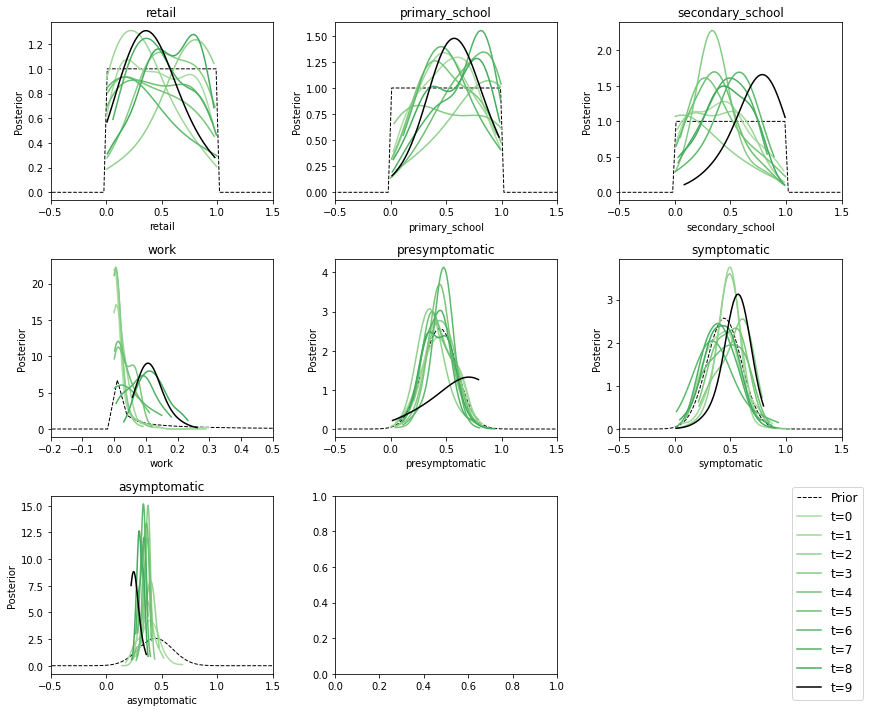

In [8]:
fig, axes = plt.subplots(3,3, figsize=(12,10))
# define colour map
evenly_spaced_interval = np.linspace(0.35, 1, 20)
colors = [cm.Greens(x) for x in evenly_spaced_interval]

for i, param in enumerate(original_priors.keys()):
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    # Add distributions
    for t in range(abc_history.max_t + 1):
        color = colors[t]
        df, w = abc_history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"t={t}", 
            color= 'black' if t==abc_history.max_t else color) # Make the last one black
        if param!="work":
            ax.set_xlim(-0.5,1.5)
        if param =='work':
             ax.set_xlim(-0.2,0.5)          
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
axes[2,2].set_axis_off()        
fig.tight_layout()
# Add legend        
fig.legend(handles, labels, loc='center right', fontsize = 12, bbox_to_anchor=(1.01, 0.17))

## 2. Assessment of the predictions made by the model within the calibration window

#### Store predictions and distances for each particle in each population 

In [9]:
n_particles = 100

# Create dictionary to store results for each population
abc_sum_stats = {}

# Loop through each population
for t in range(0,abc_history.max_t+1):
    # Create lists to store values for each particle
    data_daily_l = []
    distances_l = []

    # Get the summary stats for this population
    # ([1] means keep just the dataframe and not the array of weights)
    weighted_sum_stats = abc_history.get_weighted_sum_stats_for_model(t=t)[1]

    # Loop through each particle and save their distance and predictions into the lists
    for particle_no in range(0,n_particles):
        # Get data for just this particle
        particle_x_dict = weighted_sum_stats[particle_no]
        # Get daily predictions
        data_daily = particle_x_dict["model_daily_cumulative_infections"]     
        # Add daily msoa predictions for this particle to list
        data_daily_l.append(data_daily)
        
        # Add distances to list
        distances_l.append(particle_x_dict['distance'])
    
    # Add lists to dictionaries    
    abc_sum_stats["t{}_distances".format(t)] = distances_l
    abc_sum_stats["t{}_dailydata".format(t)] = data_daily_l

#### Create plot of daily cumulative infections with one subplot per population and one line per particle

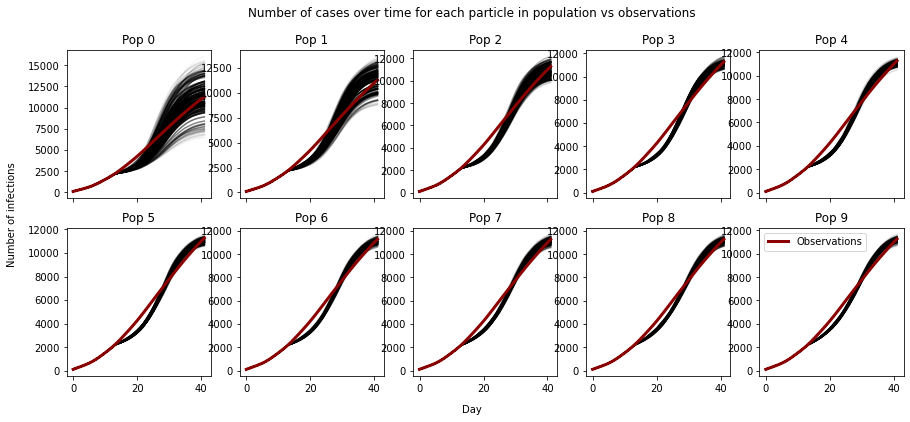

In [10]:
# Create figure
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), sharex=True)

# Loop through each population (t) and each axes on the subplot 
for t,ax in zip(range(0,abc_history.max_t+1),axs.ravel()):
    
    # Get the data for this population
    data_daily_l = abc_sum_stats["t{}_dailydata".format(t)]
    distance_l = abc_sum_stats["t{}_distances".format(t)]
    
    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
    
    # Create x axis object, with position for each day 
    day_nos = range(0,len(data_daily_l[t])) 
    
    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(data_daily_l)):
        ax.plot(day_nos, data_daily_l[i],color="black", alpha=1-distance_norm[i])  # (1-x because high distance is bad)

    # Add observations
    ax.plot(day_nos, cases_devon_daily[0:len(data_daily_l[0])], label="Observations", linewidth = 3, color="darkred")

    # Apply labels
    ax.set_title("Pop {}".format(t))

    # Set full plot title
    fig.suptitle("Number of cases over time for each particle in population vs observations")

fig.text(0.5, 0.04, 'Day', ha='center')
fig.text(0.07, 0.5, 'Number of infections', va='center', rotation='vertical')
ax.legend(fontsize="medium")

#### Create plot of daily cumulative infections with one subplot per population and the line showing the predictions of the best performing particle

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Number of cases over time for best performing particle vs observations')

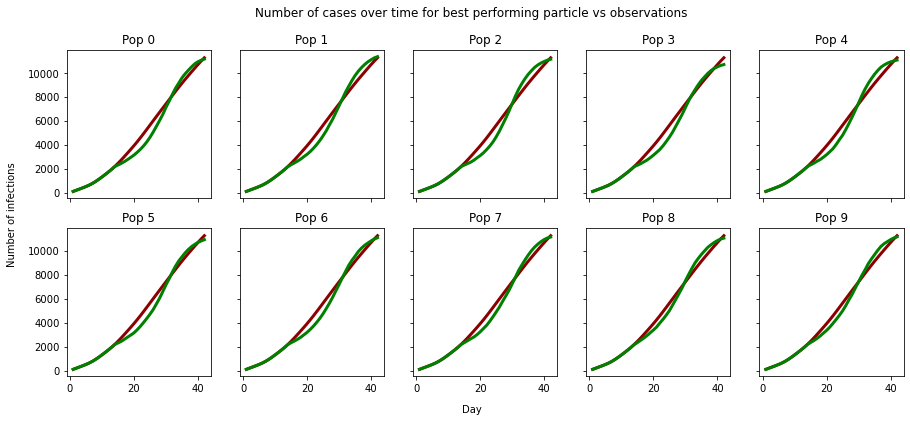

In [12]:
# Create figure
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), sharex=True, sharey = True)

# Loop through each population (t) and each axes on the subplot 
for t, ax in zip(range(0,abc_history.max_t+1),axs.ravel()):

    x = range(1, len(cases_devon_daily[0:len(data_daily_l[0])])+1)
    
    data_daily_l = abc_sum_stats["t{}_dailydata".format(t)]
    distance_l = abc_sum_stats["t{}_distances".format(t)]

    # Find the best particle
    best_particle_idx = distance_l.index(min(distance_l))
        
    # Add observations
    ax.plot(x, cases_devon_daily[0:len(data_daily_l[0])], label="Observations", linewidth = 3, color="darkred")

    # Add the best particle
    ax.plot(x, data_daily_l[best_particle_idx], color="green", linewidth = 3,label = 'Best particle')
    
    # Add text with distance value for best performing particle
    #ax.text(50, 60, 'Distance = {}'.format(round(distance_l[best_particle_idx],1)), fontsize = 10)
        
    # Apply labels
    ax.set_title("Pop {}".format(t))

fig.text(0.5, 0.04, 'Day', ha='center')
fig.text(0.07, 0.5, 'Number of infections', va='center', rotation='vertical')
fig.suptitle("Number of cases over time for best performing particle vs observations")


## 3. Model predictions for the future using parameter values from dynamic calibration

#### a. Run the model for 105 days using the posterior parameter distributions from the dynamic calibration windows

##### Set up OpenCL runner

In [13]:
## Define parameters
ITERATIONS = 105  # Number of days to run for
NUM_SEED_DAYS = 14  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")

# Define filepath to file containing default parameter values
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

# Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
# re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

# Initialise the class so that its ready to run the model.
OpenCLRunner.init(iterations = ITERATIONS,  repetitions = REPETITIONS,observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP, use_gpu = USE_GPU, store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE,opencl_dir = OPENCL_DIR, snapshot_filepath = SNAPSHOT_FILEPATH,
     num_seed_days = NUM_SEED_DAYS) 

# Set constants 
current_risk_beta_val =0.019
const_params_dict = { "current_risk_beta": current_risk_beta_val,"home": 1.0}
OpenCLRunner.set_constants(const_params_dict)


c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "


##### Use 'best-performing' particle from final population of each window of dynamic calibration to run model for 105 days

In [14]:
# Get the list of distances for the final population
distance_l = abc_sum_stats["t{}_distances".format(abc_history.max_t )]

# Find the best particle (i.e. the minimum distance)
best_particle_idx = distance_l.index(min(distance_l))

# Get the parameter values associated with each particle in final population
params_df, _w = abc_history.get_distribution(m=0, t=abc_history.max_t)

# Find the parameters associated with the best particle
best_params = params_df.iloc[best_particle_idx]

In [15]:
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(distance_bp, sim_bp, obs_bp, out_params_bp, summaries_bp) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True, quiet = False)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models:   0%|                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\gy17m2a\Anaconda3\envs\ramp-ua-min\lib\site-packages\pyopencl\__init__.py:268: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [04:41<00:00, 56.29s/it]


##### Plot the predictions against observations

Text(0, 0.5, 'Cases')

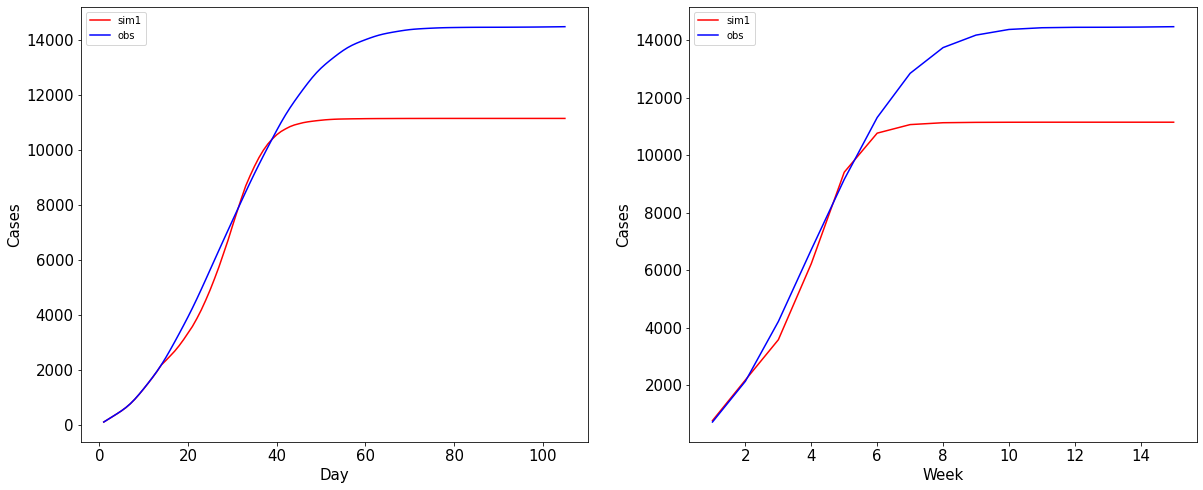

In [16]:
# Create figure
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

##### daily data
x = range(1, len(OpenCLRunner.get_cumulative_daily_infections(summaries_bp))+1)
ax1.plot(x, OpenCLRunner.get_cumulative_daily_infections(summaries_bp), label="sim1", color="red")
ax1.plot(x, cases_devon_daily[0:len(OpenCLRunner.get_cumulative_daily_infections(summaries_bp))], label="obs", color="blue")
ax1.legend()
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Day", size=15)
ax1.set_ylabel("Cases",size=15)

###### weekly data
x = range(1, len(sim_bp)+1)
ax2.plot(x, sim_bp, label="sim1", color="red")
ax2.plot(x, obs_bp, label="obs", color="blue")
ax2.legend()
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Week", size=15)
ax2.set_ylabel("Cases",size=15)   